# Mixture of linear regressions

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='ticks', font_scale=1.5)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = ['sans-serif']

np.random.seed(42)

In [2]:
# generate dataset
num_samples = 500
num_features = 10
sigma = 1.5

components = [
    {'coef': np.array([-1.47, 0.07, 0.16, -2.02, 0.14, 0.33, 0.71, 0.80, 1.53, -0.26]), 'p': 0.4},
    {'coef': np.array([-0.12, 1.38, -1.25, 0.88, -0.80, 1.33, -1.43, -0.42, 0.90, -0.47]), 'p': 0.3},
    {'coef': np.array([1.14, -1.33, 0.16, 0.23, -1.20, -0.90, 1.40, 0.98, -1.11, 0.60]), 'p': 0.3},
]

features = np.random.uniform(-10, 10, (num_samples, num_features))
observations = np.zeros(num_samples)
labels = np.zeros(num_samples, dtype=int)

component_choices = np.random.choice(len(components), size=num_samples, p=[c['p'] for c in components])
for i, comp_idx in enumerate(component_choices):
    comp = components[comp_idx]
    observations[i] = comp['coef'] @ features[i] + np.random.normal(0, sigma)
    labels[i] = comp_idx

In [3]:
### problem data
xs = features  # ndarray: dataset features
ys = observations  # ndarray: dataset observations
m = xs.shape[0]  # int: number of samples in the dataset
n = xs.shape[1]

### hyperparameters
eps = 1e-6  # float: termination criterion

### P-problem
K = 3
thetas = []  # list of cp.Variable objects: model parameters
r = []  # list of cp.Expression objects: loss functions
for k in range(K):
    thetas.append(cp.Variable(n))
    r.append(cp.square(xs @ thetas[-1] - ys))

ztil = cp.Parameter((m, K), nonneg=True)
Pobj = cp.sum(cp.multiply(ztil, cp.vstack(r).T))
Preg = 0  # cp.Expression: regularization on model parameters
Pconstr = []  # list of cp.Constraint objects: model parameter constraints
Pprob = cp.Problem(cp.Minimize(Pobj + Preg), Pconstr)
assert Pprob.is_dcp()

### F-problem
rtil = cp.Parameter((K, m))
z = cp.Variable((m, K))
Fobj = cp.sum(cp.multiply(z, rtil.T))
Freg = 0  # cp.Expression: regularization on latent factors
Fconstr = [z >= 0, z <= 1, cp.sum(z, axis=1) == 1]
Fprob = cp.Problem(cp.Minimize(Fobj + Freg), Fconstr)
assert Fprob.is_dcp()

### solve, terminate when the F- and P-objective converge
i = 0
while True:
    i += 1
    if ztil.value is None:
        ztil.value = np.random.dirichlet(np.ones(K), size=m)
    else:
        ztil.value = np.abs(z.value)
    Pprob.solve()

    rtil.value = cp.vstack(r).value
    Fprob.solve()

    print(f'Iteration {i}: P-problem value: {Pobj.value}, F-problem value: {Fobj.value}, gap: {np.abs(Pobj.value - Fobj.value)}.')
    if np.abs(Pobj.value - Fobj.value) < eps:
        break

Iteration 1: P-problem value: 136383.85792110814, F-problem value: 116771.69217014659, gap: 19612.165750961547.
Iteration 2: P-problem value: 55829.16617125887, F-problem value: 42149.31870708287, gap: 13679.847464175997.
Iteration 3: P-problem value: 33930.619794609884, F-problem value: 29651.519914652446, gap: 4279.099879957437.
Iteration 4: P-problem value: 25827.821762786698, F-problem value: 23363.13515368379, gap: 2464.686609102908.
Iteration 5: P-problem value: 20339.417642947017, F-problem value: 17563.53292676076, gap: 2775.8847161862577.
Iteration 6: P-problem value: 14142.91719906997, F-problem value: 9309.634453287286, gap: 4833.282745782684.
Iteration 7: P-problem value: 4377.0755633416275, F-problem value: 2070.654836230208, gap: 2306.4207271114196.
Iteration 8: P-problem value: 1115.6209730750209, F-problem value: 973.6640891214215, gap: 141.95688395359934.
Iteration 9: P-problem value: 938.0370018952376, F-problem value: 935.1517361812901, gap: 2.885265713947547.
Iterat

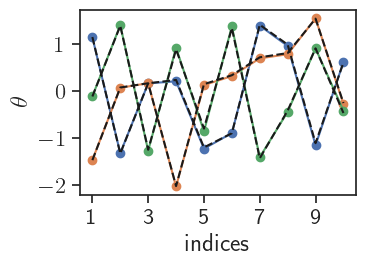

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
# ground truth coefficients
for i, comp in enumerate(components):
    axs.plot(comp['coef'], linestyle='dashed', color='k', zorder=10)
# estimated coefficients
for theta in thetas:
    axs.plot(theta.value, linewidth=1.5, marker='o')
axs.set_xticks(np.arange(0, 10, 2))
axs.set_xticklabels(np.arange(1, 11, 2))
axs.set_xlabel('indices')
axs.set_ylabel(r'$\theta$')
plt.tight_layout()

fig.savefig('../figures/mix_lin_reg.pdf', bbox_inches='tight')

In [5]:
z_hat = np.vstack([z.value[:, 1], z.value[:, 2], z.value[:, 0]]).T
acc = np.sum(np.argmax(z_hat, axis=-1) == labels) / len(labels)
print(f'Factor identification accuracy: {acc}.')

Factor identification accuracy: 0.936.
